# Precalculation of PADH Model

## Packages

In [1]:
#packages
import pandas as pd
#import seaborn as sns
import numpy as np
import tellurium as te
from tellurium import ParameterScan
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Data von Florian und Pinkus

In [2]:
# import data from florian
data_df = pd.read_csv('.././jorin/PADH_sample_set.csv')
data_df = data_df[['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰']]
data_df.head()

,Tag,OIE ‰,infected ‰,Hb (g/l),Retis ‰
0,1.0,35.849057,391.644205,9.6,NaN
1,NaN,NaN,NaN,NaN,NaN
2,3.0,199.074074,87.268519,8.1,NaN
3,4.0,350.279330,0.000000,7.6,13.3
4,NaN,NaN,NaN,NaN,NaN


In [3]:
#import Data von Pinkus 
data_df2 =  pd.read_excel('.././datasets/haemolysismodel_conRetis.xlsx')
data_df2.head()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

## Model Scheme
![model schmeme](schema_erythropoese_6.svg)


## Steady State Erythropoiesis

In [4]:
#Hb, Volume of iE

p=1e-12
f=1e-15
Vol_iE = (84*12 + ((78+79+87)/3)*36 + ((76+88+90)/3)*44)/ (12+36+44)
Hb_iE = ((p*27.5/(f*84))*12 + (((p*25/(f*78))+(p*16/(f*79))+(p*12.5/(f*87)))/3)*36 + (((p*8.5/(f*76))+(p*8.5/(f*88))+(p*9.5/(f*90)))/3)*44)/ (12+36+44)

print(f'Vol_iE:{Vol_iE} \nHb_iE:{Hb_iE} \np:{p}')

Vol_iE:83.27536231884059 
Hb_iE:179.72183309351084 
p:1e-12


In [5]:
### Steady State

t_P_aging = 9.993366387#  10    # 9,993366387 bei komplizierten Page  X
t_R_aging= 1.006633613  #1      #1,006633613 bei komplizierten Rage   X 
t_E_death= 120 

Hkt      = 0.45    #X
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_blood= 1e-6          # =1µl, in l, gesamtes Blutvolumen 
k_R_death= 5 #0.001


# E0
## E0 aus Hämatokrit-wert abgeleitet
##Hämatokrit Formel nach E umgestellt, 
##E0 = ((Hkt * Vol_blood) - (R0 * Vol_R))/Vol_E
## einfügen von R0, nach E0 umstellen

E0 = (Hkt * Vol_blood * (t_E_death/2))/ ( ((t_E_death/2)* Vol_E) + ((t_R_aging/2)*Vol_R))
R0   = E0 * t_R_aging/ t_E_death 
P0  = (R0 * (k_R_death + np.log(2)/(t_R_aging/2)))/ (2**10 *np.log(2) / (t_P_aging/2))   

J_E_death = E0* np.log(2)/(t_E_death/2)
J_R_aging = R0* np.log(2)/(t_R_aging/2)
J_R_death = R0* k_R_death

J_P_aging = P0 * np.log(2) / (t_P_aging/2) 

#EPO flux
b   = 100
c   = 0.04
hemoglobin = 137.25001  #15.281321478378196 
EPO = 15
P   = P0
d = -np.log(0.5)/P
a = EPO * (1-np.exp(-d*P))*(1+np.exp((hemoglobin-b)*c))
J_EPO_prod = a/ (1+np.exp((hemoglobin-b)*c))
J_EPO_decay = EPO * (1-np.exp(-d*P))

J_P_death = P * 1/(1+ (15/15))
J_P_birth = J_P_death + J_P_aging

#LDH
LDH = 180  #U/l
t_halb_LDH_decay= 4
J_LDH_decay=  LDH * np.log(2)/t_halb_LDH_decay
LDH_conc_E = (J_LDH_decay * Vol_blood) / (J_E_death* Vol_E +J_R_death * Vol_R)

print(f'J_R_aging+J_R_death: {J_R_aging + J_R_death} \nJ_P_aging: {J_P_aging } \nJ_P_aging*2**10: {J_P_aging*2**10 }\nJ_R_aing: {J_R_aging }\nJ_E_death: {J_E_death }\nJ_P_birth: {J_P_birth } \nJ_P_death: {J_P_death} \nJ_P_death+age: {J_P_death+ J_P_aging}')

print(f'E0:{E0} \nR0:{R0} \nR_percent:{R0/E0} \nP0:{P0} \na:{a}  \nd:{d} \nLDH_conc_E:{LDH_conc_E}  ')

J_R_aging+J_R_death: 297789.74737731996 
J_P_aging: 290.810300173164 
J_P_aging*2**10: 297789.74737731996
J_R_aing: 64308.2271046204
J_E_death: 64308.22710462041
J_P_birth: 1338.990960879373 
J_P_death: 1048.180660706209 
J_P_death+age: 1338.990960879373
E0:5566629.619931825 
R0:46696.30405453991 
R_percent:0.008388613441666666 
P0:2096.361321412418 
a:40.77822970381671  
d:0.00033064299244604415 
LDH_conc_E:1094.719085658001  


In [8]:
# SteadyState Prüfung in Model
OIE = te.loada('OIE_model.ant')

OIE.events_medication_on = False
#OIE.M = 0
OIE.BH_max = 0

OIE.k_E_infect = 0
#OIE.t_R_aging = 1    #1,006633613 bei komplizierten Rage
#OIE.t_P_aging = 10   # 9,993366387 bei komplizierten Page
#OIE.J_P_birth = 289.5362329277695

print(OIE.Hb, OIE.k_EPO_prod,OIE.J_EPO_decay, OIE.Hkt, OIE.t_E_death, OIE.t_R_aging, OIE.k_R_death)
print(f'J_R_aging+J_R_death: {OIE.J_R_aging + OIE.J_R_death} \nJ_P_aging: {OIE.J_P_aging } \nJ_P_aging*2**10: {OIE.J_P_aging*2**10 }\nJ_R_aing: {OIE.J_R_aging }\nJ_E_death: {OIE.J_E_death }\nJ_P_birth: {OIE.J_P_birth }\nLDH_conc: {OIE.LDH_conc_E } \nJ_P_death: {OIE.J_P_death} \nJ_P_death+age: {OIE.J_P_death+ OIE.J_P_aging}')
print(OIE.P * (OIE.k_P_death + OIE.k_P_aging), OIE.J_P_aging+ OIE.J_P_death, OIE.J_P_birth, OIE.LDH_conc_E)
result = OIE.simulate(0, 400, 100, ['time','R' ])
OIE.plot(result)


AttributeError: LDH_conc_E

## Medication

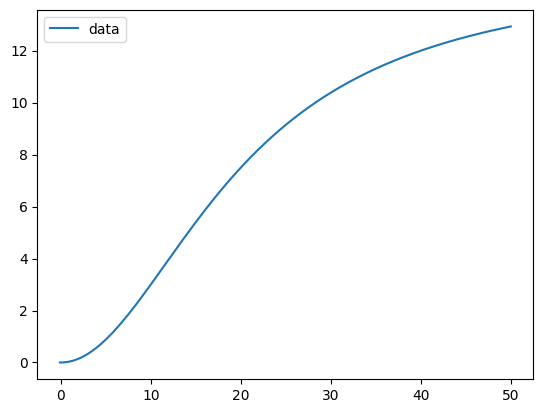

In [ ]:
I0_iE   = 0      # 0.00001 Annahme. keine oiE ohne ART medikament    inhihition die stattfindet ohne ART
I0_iE_death = 0
k_iE_kill_proportion = 0.5  #annahme Hälfte der iE die getroffen werden sterben direkt, andere Hälfte zu oiE
Imax_iE = 15 #10     #maximal inhibition-effect, Annahme:
hill    = 2.0      #hill-coefficient, muss gefittet werden (Angus 2002)
ID50    = 20

ART = np.linspace(-0.1, 50, 20000)
kiEkill = Imax_iE*(ART**hill/((ART**hill)+(ID50)**hill))
fig, ax = plt.subplots()
ax.plot(ART, kiEkill, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()

## LDH Steady State

In [ ]:
#NEUE VERSION MIT LDH GEHALT

#LDH Steady State ohne INfektion
LDH = 180  #U/l
R0 = 46391.75257731959 
Hkt      = 0.45
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_blood= 1e-6          # =1µl, in l, gesamtes Blutvolumen 

LDH_E = 27e-9 #U/Ery  #27
LDH_R = 40e-9 #U/R

t_halb_LDH_decay= 5 #4 in Model
t_R_aging= 1          
t_E_death= 120
k_R_death= 0.001

J_E_death = E0 *  np.log(2) / (t_E_death/2) #64312.62500040728
k_E_death =  np.log(2) / (t_E_death/2)
#J_R_death = 46.39175257731957


#decay
k_LDH_decay = np.log(2) /(t_halb_LDH_decay)
LDH_decay = LDH * k_LDH_decay

#release 
J_R_death = (Vol_blood * LDH_decay- J_E_death* LDH_E) /LDH_R
k0_death = J_R_death/ R0
LDH_release = (J_E_death * LDH_E + J_R_death *LDH_R)/Vol_blood # + J_R_death * 0.0001  )

#Problem schon nur LDH release duch E ist höher als abbau



LDH_release, LDH_decay, k_E_death, k0_death,  J_E_death, LDH, k_LDH_decay, LDH_E, J_R_death



In [ ]:
#LDH Steady State ohne INfektion
LDH = 180  #U/l
R0 =46391.75257731959 
Hkt      = 0.45
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_blood= 1e-6          # =1µl, in l, gesamtes Blutvolumen 

LDH_E = 27e-9 #U/Ery  #27
LDH_R = 40e-9 #U/R

t_halb_LDH_decay= 5 #4 in Model
t_R_aging= 1          
t_E_death= 120
k_R_death= 0.001

J_E_death = E0 *  np.log(2) / (t_E_death/2) #64312.62500040728
k_E_death =  np.log(2) / (t_E_death/2)
#J_R_death = 46.39175257731957


#k_R_death =( (LDH * np.log(2)) - (J_E_death* LDH_E * t_halb_LDH_decay)) / (t_halb_LDH_decay * LDH_R * R0 )

# release = decay

#decay
k_LDH_decay = np.log(2) /(t_halb_LDH_decay)
LDH_decay = LDH * k_LDH_decay

#release 
J_R_death = (Vol_blood * LDH_decay- J_E_death* LDH_E) /LDH_R
k0_death = J_R_death/ R0
LDH_release = (J_E_death * LDH_E + J_R_death *LDH_R)/Vol_blood # + J_R_death * 0.0001  )

#Problem schon nur LDH release duch E ist höher als abbau



LDH_release, LDH_decay, k_E_death, k0_death,  J_E_death, LDH, k_LDH_decay, LDH_E, J_R_death



(24.953298500158052,
 24.95329850015803,
 0.011552453009332421,
 -0.9222376490693641,
 64308.22710462041,
 180,
 0.13862943611198905,
 2.7e-08,
 -42784.22083311483)

## Haptoglobin Steady State

In [ ]:
#
HP_conc = 2                             # g/l(blood)  # 0.15-2 g/l
M_HP = 100000                           # Molare Masse von HP # https://link.springer.com/chapter/10.1007/978-3-662-48986-4_1389
N_A = 6.022e23            #Avogadokonstante
fHb_conc = 0.01  # g/l, 

###Volumen
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_iE   = 80e-15         #in l,   Jorin
Vol_oiE  = 50e-15         #in l, Jorin
Vol_blood= 1e-6           # =1µl, in l, gesamtes Blutvolumen 
###Hb Konzentrationen in g/l
Hb_conc_R   = 300        #in g/l (Piva,2014) 
Hb_conc_E   = 340        #in g/l,  =MCHC, https://www.ucsfhealth.org/medical-tests/rbc-indices    
Hb_conc_iE  = 180        #in g/l  (Hanssen,2012)-> unbedingt nochmal überprüfen
Hb_conc_oiE = 180        #Annahme: als gleiche Höhe wie iE
### Hb Konzentrationen in 1/l
M_Hb = 64500              # g/mol, Molare Masse 
Hb_factor = N_A * M_Hb
Hb_count_R = Hb_conc_R * Hb_factor
Hb_count_E = Hb_conc_E * Hb_factor
Hb_count_iE = Hb_conc_iE * Hb_factor
Hb_count_oiE = Hb_conc_oiE * Hb_factor

HP   =  N_A * HP_conc / (M_HP * Vol_blood) # 1/mikroliter

J_R_death = 46.6963040545399 
J_E_death =64308.22710462046

t_halb_HP_decay = 5     
t_halb_HCC_decay = 0.00694  

k_HCC_decay = np.log(2)/ t_halb_HCC_decay
k_HP_decay = np.log(2)/ t_halb_HP_decay

J_fHb_release = (Hb_count_R * J_R_death * Vol_R + Hb_count_E * J_E_death * Vol_E ) / Vol_blood

fHb =  N_A * fHb_conc / (M_Hb * Vol_blood) # 1/mikroliter
k_HCC_bind = J_fHb_release / (fHb * HP)
J_HP_decay = HP * k_HP_decay 
J_HCC_binding = HP * fHb * k_HCC_bind
HCC =  J_HCC_binding * (1/k_HCC_decay)
J_HCC_decay   = HCC * k_HCC_decay
J_HP_prod  = J_HP_decay + J_HCC_binding
k_HCC_bind = J_fHb_release / (fHb * HP)


print(f'HCC:{HCC} \nk_HCC_bind:{k_HCC_bind} \nfHb:{fHb} \nHP:{HP} ')

print(f'J_fHb_release :{J_fHb_release } \nJ_HCC_binding:{J_HCC_binding}')

print(f'J_HP_prod:{J_HP_prod} \nJ_HP_decay+J_HCC_binding:{J_HP_decay+J_HCC_binding} \nJ_HP_decay:{J_HP_decay}')

print(f'J_HCC_binding {J_HCC_binding  } \nJ_HCC_decay :{J_HCC_decay }')

print(f'J_R_death:  {J_R_death  } \nJ_E_death  :{J_E_death }')

HCC:6.807969404328303e+26 
k_HCC_bind:6.046886298783305e-20 
fHb:9.336434108527133e+22 
HP:1.2044e+25 
J_fHb_release :6.799603455257253e+28 
J_HCC_binding:6.799603455257253e+28
J_HP_prod:6.799770420550107e+28 
J_HP_decay+J_HCC_binding:6.799770420550107e+28 
J_HP_decay:1.6696529285327961e+24
J_HCC_binding 6.799603455257253e+28 
J_HCC_decay :6.799603455257253e+28
J_R_death:  46.6963040545399 
J_E_death  :64308.22710462046


In [ ]:
# SteadyState Prüfung in Model
OIE = te.loada('OIE_model_new.ant')

OIE.events_medication_on = False
OIE.BH_max = 0
OIE.switch_fHb= 0
OIE.k_E_infect = 0

print(f'HCC:{OIE.HCC} \nk_HCC_bind:{OIE.k_HCC_bind} \nfHb:{OIE.fHb} \nHP:{OIE.HP} ')

print(f'J_fHb_release :{OIE.J_fHb_release } \nJ_HCC_binding:{OIE.J_HCC_binding}')

print(f'J_HP_prod:{OIE.J_HP_prod} \nJ_HP_decay+J_HCC_binding:{OIE.J_HP_decay+OIE.J_HCC_binding} \nJ_HP_decay:{OIE.J_HP_decay} \nk_HP_decay: {OIE.k_HP_decay}')

print(f'J_HCC_binding {OIE.J_HCC_binding  } \nJ_HCC_decay :{OIE.J_HCC_decay }')

print(f'J_R_death:  {OIE.J_R_death  } \nJ_E_death  :{OIE.J_E_death }')

#print(1/ (1+ np.exp(-(0))))

HCC:4.940771001764969e-07 
k_HCC_bind:15.91440605788467 
fHb:0.0001550387596899225 
HP:0.02 
J_fHb_release :4.934699552832456e-05 
J_HCC_binding:4.934699552832456e-05
J_HP_prod:0.0028219357177681056 
J_HP_decay+J_HCC_binding:0.0028219357177681056 
J_HP_decay:0.002772588722239781 
k_HP_decay: 0.13862943611198905
J_HCC_binding 4.934699552832456e-05 
J_HCC_decay :4.934699552832456e-05
J_R_death:  46.6963040545399 
J_E_death  :64308.22710462046


In [ ]:
#
HP_conc = 2                             # g/l(blood)  # 0.15-2 g/l
M_HP = 100000                           # Molare Masse von HP # https://link.springer.com/chapter/10.1007/978-3-662-48986-4_1389
N_A = 6.022e23            #Avogadokonstante
fHb_conc = 0.01  # g/l, 
Hkt = 0.45

###Volumen
Vol_R    = 100e-15        #in l, Jorin
Vol_E    = 80e-15         #=80 fL, in l, Jorin, =MCH
Vol_iE   = 80e-15         #in l,   Jorin
Vol_oiE  = 50e-15         #in l, Jorin
Vol_blood= 1e-6           # =1µl, in l, gesamtes Blutvolumen 
Vol_plasma = (1-Hkt)* Vol_blood
###Hb Konzentrationen in g/l
Hb_conc_R   = 300        #in g/l (Piva,2014) 
Hb_conc_E   = 340        #in g/l,  =MCHC, https://www.ucsfhealth.org/medical-tests/rbc-indices    
Hb_conc_iE  = 180        #in g/l  (Hanssen,2012)-> unbedingt nochmal überprüfen
Hb_conc_oiE = 180        #Annahme: als gleiche Höhe wie iE
### Hb Konzentrationen in mol/mikroliter
M_Hb = 64500              # g/mol, Molare Masse 
HP = 1000* HP_conc/ M_HP  # mmol/liter

J_R_death = 46.6963040545399 
J_E_death =64308.22710462046

t_halb_HP_decay = 5     
t_halb_HCC_decay = 0.00694  

k_HCC_decay = np.log(2)/ t_halb_HCC_decay
k_HP_decay = np.log(2)/ t_halb_HP_decay

J_fHb_release = (Hb_conc_R * J_R_death * Vol_R + Hb_conc_E * J_E_death * Vol_E ) / (M_Hb * Vol_plasma)


fHb =  1000* fHb_conc / M_Hb                  # mmol/mikroliter
k_HCC_bind = J_fHb_release / (fHb * HP)
J_HP_decay = HP * k_HP_decay 
J_HCC_binding = HP * fHb * k_HCC_bind
HCC =  J_HCC_binding * (1/k_HCC_decay)
J_HCC_decay   = HCC * k_HCC_decay
J_HP_prod  = J_HP_decay + J_HCC_binding
k_HCC_bind = J_fHb_release / (fHb * HP)


print(f'HCC: {HCC} \nk_HCC_bind: {k_HCC_bind} \nfHb: {fHb} \nHP: {HP} ')

print(f'J_fHb_release:{J_fHb_release } \nJ_HCC_binding: {J_HCC_binding}')

print(f'J_HP_prod: {J_HP_prod} \nJ_HP_decay+J_HCC_binding: {J_HP_decay+J_HCC_binding} \nJ_HP_decay:{J_HP_decay} \nk_HP_decay:{k_HP_decay}')

print(f'J_HCC_binding: {J_HCC_binding  } \nJ_HCC_decay: {J_HCC_decay }')

print(f'J_R_death: {J_R_death  } \nJ_E_death:{J_E_death }')

HCC: 4.940771001764966e-07 
k_HCC_bind: 15.91440605788466 
fHb: 0.0001550387596899225 
HP: 0.02 
J_fHb_release:4.934699552832453e-05 
J_HCC_binding: 4.934699552832453e-05
J_HP_prod: 0.0028219357177681056 
J_HP_decay+J_HCC_binding: 0.0028219357177681056 
J_HP_decay:0.002772588722239781 
k_HP_decay:0.13862943611198905
J_HCC_binding: 4.934699552832453e-05 
J_HCC_decay: 4.9346995528324536e-05
J_R_death: 46.6963040545399 
J_E_death:64308.22710462046


### P death regulation

176.34229468244587


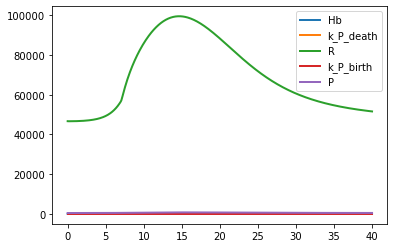

176.32183504040196


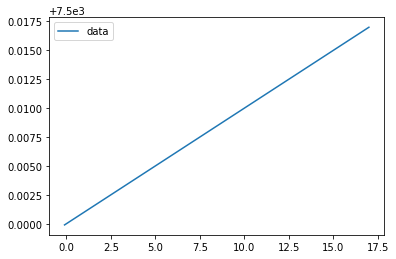

/tmp/ipykernel_103077/3488201470.py:31: RuntimeWarning:

overflow encountered in exp



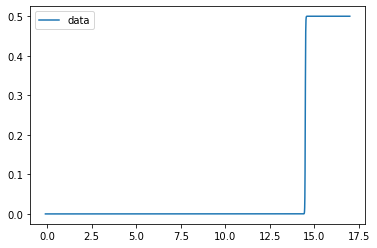

In [10]:
#param1_Pdeath * Hb + param2_Pdeath 


#J_oiE_death
OIE = te.loada('.././model/OIE_model.ant')
print(OIE.k_P_death+ OIE.k_P_birth)
result = OIE.simulate(0,40,500, ['time', 'Hb', 'k_P_death', 'R', 'k_P_birth', 'P'] )
OIE.plot(result)
print(OIE.k_P_death+ OIE.k_P_birth)


#Pdeath depends on Hb linear
param1 = 0.001
param2 = 7500
Hb = np.linspace(-0.1, 17, 20000)
k_P_death = param1 * Hb + param2
fig, ax = plt.subplots()
ax.plot(Hb, k_P_death, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()

#k_P_death, 0 = 0.5
#Hb,0 = 14.5

#Pdeath depends on Hb sigmoidal
param1 = 0.5
param2 = 1e0
param3 = 14.5      #Hb,0
Hb = np.linspace(-0.1, 17, 20000)
k_P_death = param1/ (1+ np.exp(-param2*(Hb -param3)))
fig, ax = plt.subplots()
ax.plot(Hb, k_P_death, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()



### Switches

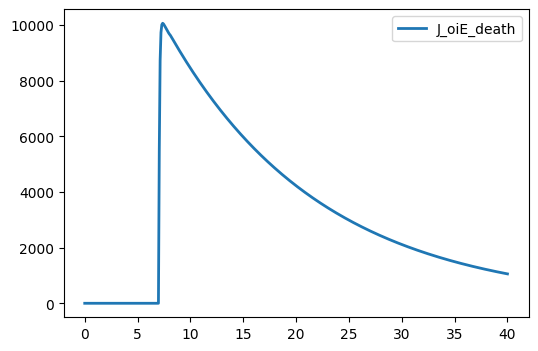

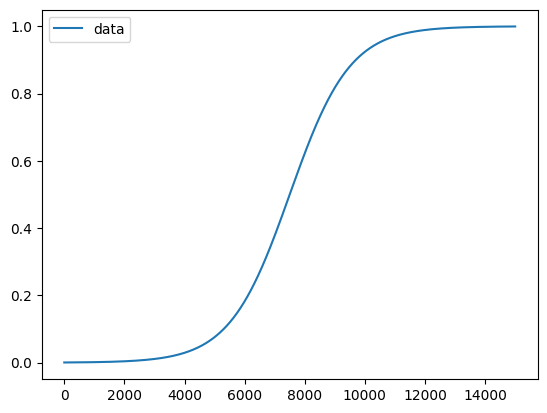

In [ ]:
#J_oiE_death
OIE = te.loada('OIE_model.ant')
result = OIE.simulate(0,40,500, ['time', 'J_oiE_death'] )
OIE.plot(result)

#Switch oiEdeath
param1 = 0.001
param2 = 7500
x = np.linspace(-0.1, 15000, 20000)
y =   1/ (1+ np.exp(-param1*(x - param2)))
fig, ax = plt.subplots()
ax.plot(x, y, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()


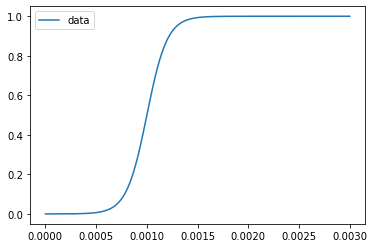

105

In [ ]:
#Switch fHb

#bei 5-10x fache von SS Wert von fHb ist switch 50% von max 
#SS: 

x = np.linspace(0, 0.003, 20000)
y =   1/ (1+ np.exp(-1e4*(x -0.001)))
fig, ax = plt.subplots()
ax.plot(x, y, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()


### HP Production


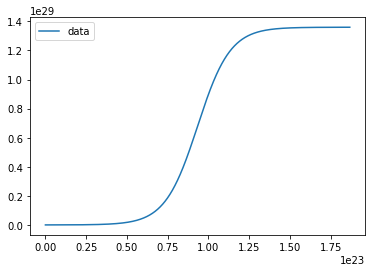

7.3151636712327975e+28

In [ ]:
#HP production
x = np.linspace(-0.1, 2*9.33643410852713e+22, 20000)
y = 2* 6.799770420550107e+28 / (1+ np.exp(-1e-22*(x-9.33643410852713e+22)))
fig, ax = plt.subplots()
ax.plot(x, y, label='data')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()


#max = 2* J_HP_decay + J_HCC_binding = 2* 7.3151636712327975e+28

2* 7.3151636712327975e+28 / (1+ np.exp(-1e-22*(9.33643410852713e+22-9.33643410852713e+22)))

## Precaluclations RPI
- maturation time Precursor, Retis

-4.999999999999998 3.25


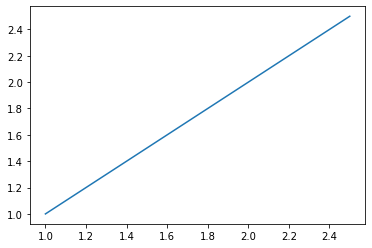

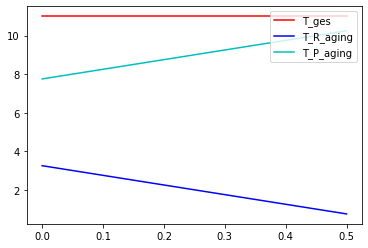

In [ ]:
#RPI Zusammenhang Hamatokrit und Reifungstage von Retis in peripheren Blut (R) und Retis die in Knochenmark noch sind (Teil von P)
# https://www.labopart.de/einsender/formelberechnungen/rpi/
# s. Manuskript für Formel

HK = [0.15, 0.25, 0.35, 0.45] 
days_T_R_aging = [2.5, 2.0, 1.5, 1.0]
#lineare Regression for function:  y = m*x +b
m,b = np.polyfit(HK, days_T_R_aging, 1)
print(m,b)
plt.plot(days_T_R_aging, days_T_R_aging)
plt.show()



#x-values, and y Functions for R aging and T aging
Hkt = np.linspace(0, 0.5, 100)
T_P_aging = 5 * Hkt + 7.75
T_R_aging =-5 * Hkt + 3.25
T_ges     = T_P_aging + T_R_aging

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(Hkt,T_ges, 'r', label='T_ges')
plt.plot(Hkt,T_R_aging, 'b', label='T_R_aging')
plt.plot(Hkt,T_P_aging, 'c', label='T_P_aging')
plt.legend(loc='upper right')
plt.show()



In [ ]:
#sigmoidales Fitting von T_R_aging & T_P_aging

#T_R_aging
def sigmoid_R(x, c,k, x0):
     y = c*1 / (1 + np.exp(-k*(x-x0)))
     return y

xdata_HK = np.array([0.15, 0.25, 0.35, 0.45]) 
ydata_days_T_R_aging = np.array([2.5, 2.0, 1.5, 1.0])

popt, pcov = curve_fit(sigmoid_R, xdata_HK, ydata_days_T_R_aging )
print (popt)
x = np.linspace(-0.1, 1, 50)
y = sigmoid_R(x, *popt)

fig, ax = plt.subplots()
ax.plot(xdata_HK, ydata_days_T_R_aging, label='data')
ax.plot(x,y, label='fit')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()


fig, ax = plt.subplots()
ax.plot(xdata_HK, ydata_days_T_P_aging, label='data')
ax.plot(x,y, label='fit')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()
y = 11-(c*1 / (1 + np.exp(-k*(x-x0))))
return y

xdata_HK = np.array([0.15, 0.25, 0.35, 0.45]) 
ydata_days_T_P_aging = np.array([11-2.5, 11-2.0, 11-1.5, 11-1.0])

print(ydata_days_T_P_aging)
popt, pcov = curve_fit(sigmoid_T, xdata_HK, ydata_days_T_P_aging )
print (popt)
x = np.linspace(-0.1, 1, 50)
y = sigmoid_T(x, *popt)

fig, ax = plt.subplots()
ax.plot(xdata_HK, ydata_days_T_P_aging, label='data')
ax.plot(x,y, label='fit')
#pylab.ylim(0, 5)
ax.legend(loc='best')
plt.show()

print(3.53276388*1 / (1 + np.exp(5.99745537*(0-0.29658879)))+ 11-(3.53276388*1 / (1 + np.exp(5.99745537*(0-0.29658879)))))

: 

: 

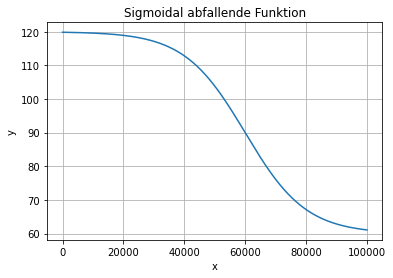

'\nt_E_death := param1_TEdeath / (1 + exp  (param2_TEdeath * (oiE - param3_TEdeath))) + param4_TEdeath  \n\n#parameter für t1/2 death von Erys (wird verlürzt wenn oiE da sind)\nparam1_TEdeath = 120 - param4_TEdeath   \nparam2_TEdeath = 0.0001\nparam3_TEdeath = 60000\nparam4_TEdeath = 80      #(t1/2 wird halbiert wenn hohe oiE-Konz. da sind)\n'

In [ ]:
#t1/2 von T_death abhängig von oiE-Konzentration


def sigmoidal_function(x):
    d = 60
    a = 120-d   # Anpassen des Versatzes in y-Richtung
    b = 0.0001   # Anpassen der Steigung
    c = 60000    # Anpassen des Versatzes in x-Richtung
    

    y = a / (1 + np.exp(b * (x - c))) + d  # Sigmoidal abfallende Funktion

    return y

# Erstellen der x- und y-Daten
x = np.linspace(0, 100000, 1000)
y = sigmoidal_function(x)

# Erstellen des Plots
plt.plot(x, y)
plt.title('Sigmoidal abfallende Funktion')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


"""
t_E_death := param1_TEdeath / (1 + exp  (param2_TEdeath * (oiE - param3_TEdeath))) + param4_TEdeath  

#parameter für t1/2 death von Erys (wird verlürzt wenn oiE da sind)
param1_TEdeath = 120 - param4_TEdeath   
param2_TEdeath = 0.0001
param3_TEdeath = 60000
param4_TEdeath = 80      #(t1/2 wird halbiert wenn hohe oiE-Konz. da sind)
"""

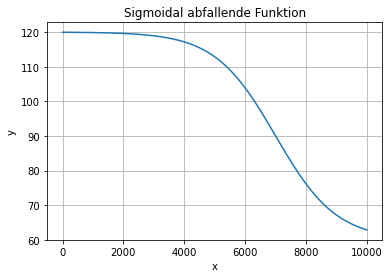

'\nt_E_death := param1_TEdeath / (1 + exp  (param2_TEdeath * (J_oiE_death - param3_TEdeath))) + param4_TEdeath  \n\n#parameter für t1/2 death von Erys (wird verlürzt wenn oiE da sind)\nparam1_TEdeath = 120 - param4_TEdeath   \nparam2_TEdeath = 0.001\nparam3_TEdeath = 7000\nparam4_TEdeath = 60      #(t1/2 wird halbiert wenn hohe oiE-Konz. da sind)\n'

In [ ]:
#t1/2 von T_death abhängig von oiE-Sterben


def sigmoidal_function(x):
    d = 60
    a = 120-d   # Anpassen des Versatzes in y-Richtung
    b = 0.001   # Anpassen der Steigung
    c = 7000    # Anpassen des Versatzes in x-Richtung
    

    y = a / (1 + np.exp(b * (x - c))) + d  # Sigmoidal abfallende Funktion

    return y

# Erstellen der x- und y-Daten
x = np.linspace(0, 10000, 1000)
y = sigmoidal_function(x)

# Erstellen des Plots
plt.plot(x, y)
plt.title('Sigmoidal abfallende Funktion')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


"""
t_E_death := param1_TEdeath / (1 + exp  (param2_TEdeath * (J_oiE_death - param3_TEdeath))) + param4_TEdeath  

#parameter für t1/2 death von Erys (wird verlürzt wenn oiE da sind)
param1_TEdeath = 120 - param4_TEdeath   
param2_TEdeath = 0.001
param3_TEdeath = 7000
param4_TEdeath = 60      #(t1/2 wird halbiert wenn hohe oiE-Konz. da sind)
"""

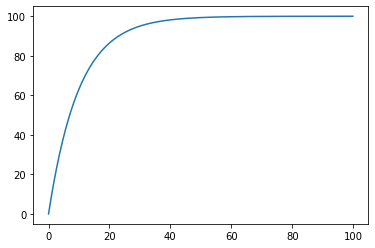

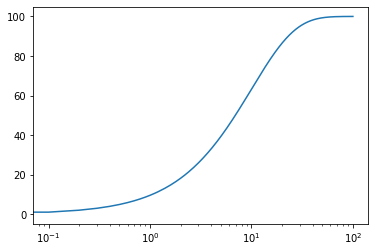

9.826843611112658

In [ ]:
#grobes Raten für Killig rate durch ART, 4.545
x = np.arange(0, 100, 0.1)
y = 100*(1-np.exp(-x*0.1))+ 0.01

fig, ax = plt.subplots()
ax.plot(x,y)
plt.show()

fig, ax = plt.subplots()
ax.semilogx(x,y)
plt.show()

10*(1-np.exp(-40*0.1))+0.01

## Simulation

In [ ]:
# load model from ant-Data
""" OIE = te.loada('OIE_model.ant')


OIE.events_medication_on = False
OIE.M = 0
OIE.switch_oiE = 0
OIE.t_R_aging = 1
OIE.t_P_aging = 10

print(OIE.J_R_aging, OIE.J_E_death)

result = OIE.simulate(7, 100, 100, ['time','k_P_death'])
OIE.plot(result)

print(OIE.t_R_aging)

OIE = te.loada('OIE_model.ant')
OIE.events_medication_on = False
OIE.M = 0
OIE.switch_oiE = 0
result = OIE.simulate(7, 100, 100, ['time','R'])
OIE.plot(result)


print(OIE.E) """

" OIE = te.loada('OIE_model.ant')\n\n\nOIE.events_medication_on = False\nOIE.M = 0\nOIE.switch_oiE = 0\nOIE.t_R_aging = 1\nOIE.t_P_aging = 10\n\nprint(OIE.J_R_aging, OIE.J_E_death)\n\nresult = OIE.simulate(7, 100, 100, ['time','k_P_death'])\nOIE.plot(result)\n\nprint(OIE.t_R_aging)\n\nOIE = te.loada('OIE_model.ant')\nOIE.events_medication_on = False\nOIE.M = 0\nOIE.switch_oiE = 0\nresult = OIE.simulate(7, 100, 100, ['time','R'])\nOIE.plot(result)\n\n\nprint(OIE.E) "

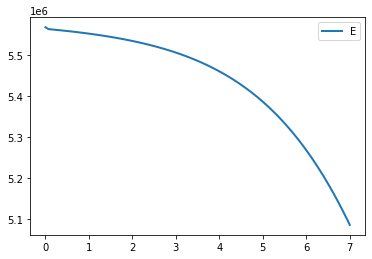

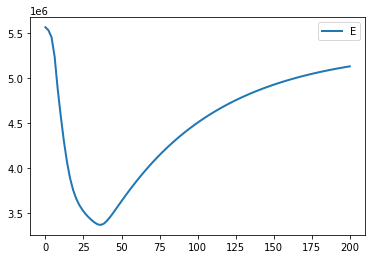

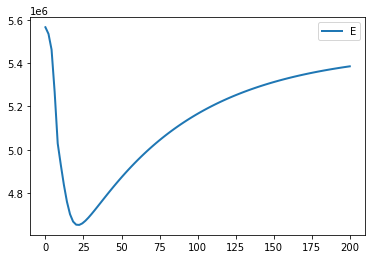

In [ ]:
# load model from ant-Data
OIE = te.loada('OIE_model.ant')
OIE.switch_oiE = 0
result = OIE.simulate(0, 7, 100,  ['time','E'])
OIE.plot(result)

OIE = te.loada('OIE_model.ant')
OIE.switch_oiE = 1
result = OIE.simulate(0, 200, 100,  ['time','E'])
OIE.plot(result)

OIE = te.loada('OIE_model.ant')
OIE.BH_max = 1
result = OIE.simulate(0, 200, 100,  ['time','E'])
OIE.plot(result)

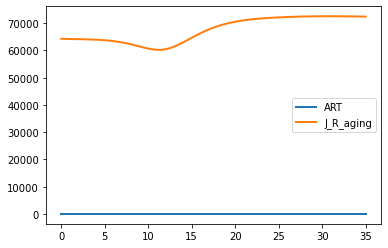

4.651982468725789

In [ ]:
# load model from ant-Data
OIE = te.loada('OIE_model.ant')

OIE.events_medication_on = False
# Simulate model
result = OIE.simulate(0, 35, 100,  ['time','ART', 'J_R_aging'])

OIE.plot(result)

OIE.R_percent


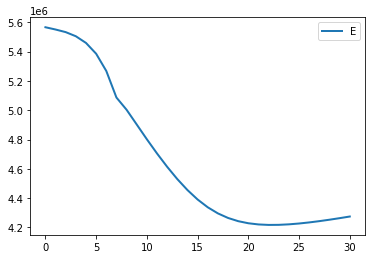

In [ ]:
# load model from ant-Data
OIE = te.loada('OIE_model.ant')
# Simulate model

result = OIE.simulate(0,30, 31,  ['time', 'E'])

OIE.plot(result)



In [ ]:
selection = ['time','M', 'iE', 'E', 'diE', 'oiE', 'parasitemia', 'k_M_death']
sim_days=150

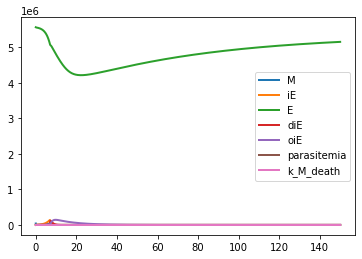

In [ ]:
OIE = te.loada('OIE_model.ant')
result_with_events = OIE.simulate (0, sim_days, 1000, selection)
OIE.plot(result_with_events)

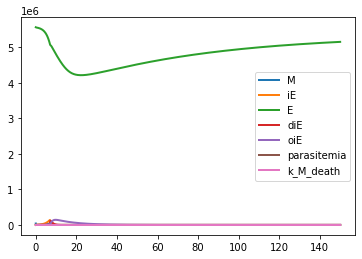

In [ ]:
OIE = te.loada('OIE_model.ant')
OIE.events_on = False
result_no_events = OIE.simulate (0, sim_days, 1000, selection)
OIE.plot(result_no_events)

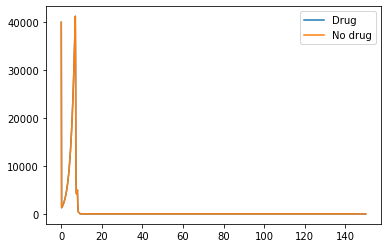

In [ ]:
fig, ax = plt.subplots()
ax.plot(result_with_events['time'], result_with_events['M'], label='Drug')
ax.plot(result_no_events['time'], result_no_events['M'], label='No drug')
ax.legend()
#ax.set_yscale('log')
plt.show()

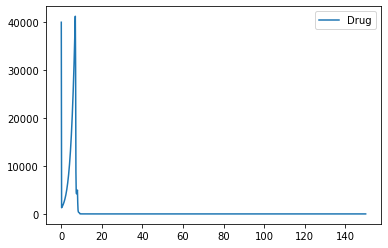

In [ ]:
fig, ax = plt.subplots()
ax.plot(result_with_events['time'], result_with_events['M'], label='Drug')
#ax.plot(result_no_events['time'], result_no_events['p'], label='No drug')
ax.legend()
#ax.set_yscale('log')
plt.show()

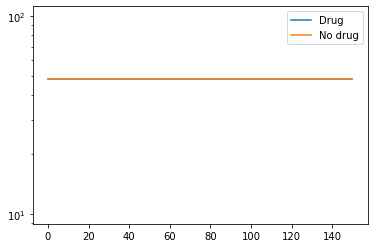

In [ ]:
fig, ax = plt.subplots()
ax.plot(result_with_events['time'], result_with_events['k_M_death'], label='Drug')
ax.plot(result_no_events['time'], result_no_events['k_M_death'], label='No drug')
ax.legend()
ax.set_yscale('log')
plt.show()

400.09768569882664


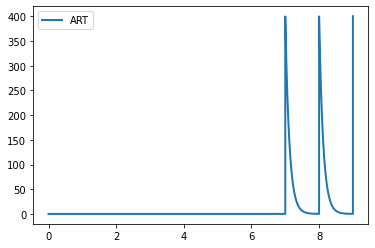

400.09768569882664

In [ ]:
OIE = te.loada('OIE_model.ant')
result = OIE.simulate (0,9, 50000, ['time', 'ART'])
print(OIE.ART)
OIE.plot(result)
OIE.ART

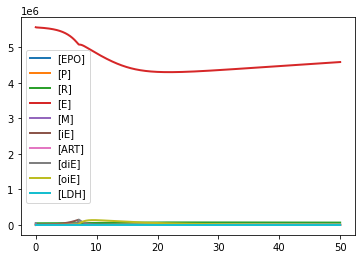

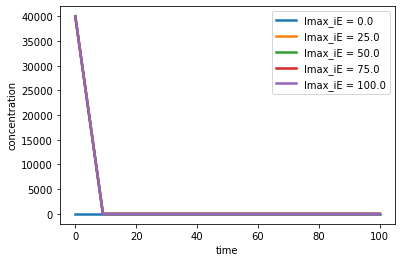

0.0

In [ ]:
OIE = te.loada('OIE_model.ant') 
OIE.setValue("Imax_iE", 100) 
result = OIE.simulate (0, 50 ,1000)
OIE.plot(result)

p = ParameterScan(OIE)
p.endTime = 100
p.numberOfPoints = 12
p.polyNumber = 5
p.startValue = 0
p.endValue = 100
p.value = 'Imax_iE'
p.selection = ['M']

p.plotGraduatedArray()

OIE.iE
#(5*(1-np.exp(-0*0.1))) + 0.1

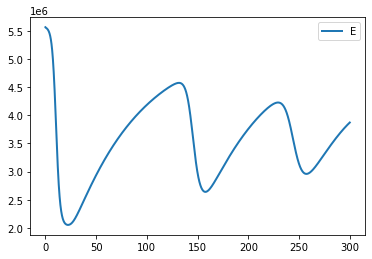

(136.61277590482794, 0.0894252199205157)

In [ ]:
OIE = te.loada('OIE_model.ant')
#OIE.setValue("k_E_infect",  1e-6) 
#OIE.setValue("k_iE_death", 0.01) 
OIE.events_medication_on = False

result = OIE.simulate (0, 300,5000, ['time', 'E'])
OIE.plot(result)

OIE.LDH, OIE.parasitemia

0.0


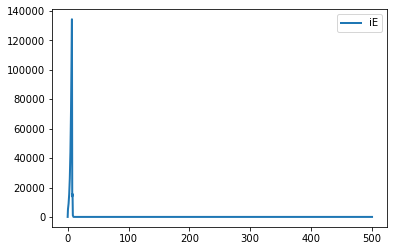

4.589215615660412e-45

In [ ]:
OIE = te.loada('OIE_model.ant')
print(OIE.iE)
#OIE.setValue("E", 9*10**6) 
result = OIE.simulate (0, 500 ,1000,['time', 'iE'])
OIE.plot(result)

OIE.iE

In [ ]:
OIE = te.loada('OIE_model.ant')
print(OIE.f)
OIE.setValue("f", 0.01) 
result = OIE.simulate (0, 500 ,1000,['time', 'iE'])
OIE.plot(result)

OIE.iE

AttributeError: f

In [ ]:
## Plotting 

## Delay einbauen

In [ ]:
s = ''.join([f'R{i}: S{i} -> S{i+1}; k_age\n' for i in range(10)])
print(s)

In [ ]:
aging_R = ''.join([f'R{i}: S{i} -> S{i+1}; k_age * S{i}\n' for i in range(3)])
aging_E = ''.join([f'R{i}: S{i} -> S{i+1}; k_age\n' for i in range(3, 6)])
                  

model = """
balh;
{a_R}
blub;
{a_E}
""".format(a_R=aging_R, a_E=aging_E)

print(model)

## Parameter Scanning

###Tellurium Scan

In [ ]:
#k_iE_kill  := e*(1-exp(-ART*f))+g 

OIE = te.loada('OIE_model.ant')
print(OIE.e)
#OIE.setValue("g", 0) 
OIE.setValue("e", 100) 
result = OIE.simulate (0, 30 ,1000)
OIE.plot(result)
print(OIE.iE)
print(OIE.p)

p = ParameterScan(OIE)
p.endTime = 20
p.numberOfPoints = 1000000
p.polyNumber = 5
p.startValue = 0
p.endValue = 100
p.value = 'f'
p.selection = ['iE']

p.plotGraduatedArray()

#(5*(1-np.exp(-0*0.1))) + 0.1

### small parameter scanning

In [ ]:
imaxie_values = np.linspace(0, 10, 10)
res=[]
for imaxie in imaxie_values:
    OIE = te.loada('OIE_model.ant')
    OIE.setValue('Imax_iE', imaxie)
    result = OIE.simulate(0, 20,200, ['time', 'p'])
    res.append(result)
    
fig, ax = plt.subplots()
for i, result in enumerate(res):
    ax.plot(result['time'], result['p'], label=f'Imax_iE = {np.round(imaxie_values[i], 2)}')
ax.legend()
#ax.set_xlim(7, 10)
plt.show()

In [ ]:
"""hilli_values = np.linspace(0.1, 2, 10)
res=[]
for hilli in hilli_values:
    OIE = te.loada('OIE_model.ant')
    OIE.setValue('hill', hilli)
    result = OIE.simulate(0, 20, 200,['time', 'p'])
    res.append(result)
    
fig, ax = plt.subplots()
for i, result in enumerate(res):
    ax.plot(result['time'], result['p'], label=f'hill = {np.round(imaxie_values[i], 2)}')
ax.legend()
#ax.set_xlim(7, 10)
plt.show()"""

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = []
readout = {
    "steady_state": lambda t,x:x[-1],
    #"max": lambda t,x: np.max(x),
    #"t_max": lambda t,x: t[np.argmax(x)]
}

para = 'k_E_infect'
fluxes = ['J_E_infect', 'J_iE_death', 'J_iE_rupture', 'J_M_death']

for i in np.logspace(-2,2,100):
    OIE = te.loada('OIE_model.ant')
    p_value = i*OIE.getValue(para)
    OIE.setValue(para, p_value) 
    result = OIE.simulate (0, 10000, 1000, ["time",'M'])
    for k,v in readout.items():
        df.append({"p_name":para,"p_value":p_value,"i":i,"readout":k,"value":v(np.array(result[:,0]),np.array(result[:,1])),"species":'OIE.M'})

df = pd.DataFrame(df)

In [ ]:
#filter_df = lambda df:df.loc[df["p_name"].isin(['k_E_infect', 'k_iE_rupture','k_iE_death'])]
filter_df = lambda df:df.loc[(df["p_name"].isin(['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']))& (~df["species"].isin(["EPO", 'R', 'P', 'oiE', 'diE']))]

#g = sns.FacetGrid(data = df.loc[df["p_name"] == "k_E_infect"], col = "species",row = "readout", hue = "p_name", sharey=False)
g = sns.FacetGrid(data = filter_df(df), col = "species",row = "readout", hue = "p_name", sharey=False)
g.map_dataframe(sns.lineplot,"i","value").set(xscale = 'log')
g.add_legend()

### big parameter scanning

In [ ]:
#OIE.getSimulationData()
OIE.selections
OIE.getFloatingSpeciesIds()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = []

readout = {
    "steady_state": lambda t,x:x[-1],
    #"max": lambda t,x: np.max(x),
    #"t_max": lambda t,x: t[np.argmax(x)]
}

para = ['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']
fluxes = ['J_E_infect', 'J_iE_death', 'J_iE_rupture', 'J_M_death']
outputlist = OIE.getFloatingSpeciesIds()+fluxes

OIE = te.loada('OIE_model.ant')
for p_name in para:
#for p_name in OIE.getGlobalParameterIds()[0:5]:
    print(p_name)
    for i in np.logspace(-1,1,100):
        try:
            OIE = te.loada('OIE_model.ant')
            p_value = i*OIE.getValue(p_name)
            OIE.setValue(p_name, p_value) 
            
        except Exception as e:continue
        result = OIE.simulate (0, 1000, 1000, ["time"] + outputlist)
        for o,species in enumerate(outputlist):
            for k,v in readout.items():
                df.append({"p_name":p_name,"p_value":p_value,"i":i,"readout":k,"value":v(np.array(result[:,0]),np.array(result[:,o+1])),"species":species})

df = pd.DataFrame(df)

In [ ]:
#filter_df = lambda df:df.loc[df["p_name"].isin(['k_E_infect', 'k_iE_rupture','k_iE_death'])]
filter_df = lambda df:df.loc[(df["p_name"].isin(['k_E_infect', 'k_M_death', 'k_iE_rupture','k_iE_death']))& (~df["species"].isin(["EPO", 'R', 'P']))]

#g = sns.FacetGrid(data = df.loc[df["p_name"] == "k_E_infect"], col = "species",row = "readout", hue = "p_name", sharey=False)
g = sns.FacetGrid(data = filter_df(df), col = "species",row = "readout", hue = "p_name", sharey=False)
g.map_dataframe(sns.lineplot,"i","value").set(xscale = 'log')
g.add_legend()